# MLOps Walkthrough - Model Evaluation



### Understanding, evaluating and reusing ML assets

### Key Principles
* reusable components - making model results available to other researchers
* running at scale - serving many results
* interactive exploration of results (predictions and XAI)

### Key Tasks for RSEs
* Setting up infrastrcuture to serve models and model results
* Creating model evaluation and testing suites/workflows to evaluate model performance in a reproducible and comparable way
* Supporting tools for interpretability and explainability (XAI)
* Creating dashboard for ML outputs including
  * predictions from inference
  * performance metrics
  * explainability metrics


### Key Terms
* inference
* XAI
* explainabiliuty
* interpretability
* metrics


### Key Tools
* model storage/loading (mlflow, onnx)
* inference (mlflow, ray serve)
* workflow (ray)
* metrics (scikit learn)
* XAI (scikit learn, shap, omni xai)
* dashboards (matplotlib, bokeh, holoviz)

### Running this notebook
This notebook should run from a conda environment created with the [requirements_evaluation.yml file](requirements_evaluation.yml). See the readme file for info on how to set up a conda environment for using this notebook.

## Loading trained models for inference

Once you've trained a model, or more usually in a research several different models to explore different options for you model such as different model architectures, different input features or different training datasets, you then want to evaluate the performance of each model (using performance metrics) and also understand how it is making (using interpretability and explainability techniques).



In [1]:
import datetime
import os
import pathlib
import functools

In [2]:
import intake

In [3]:
import numpy
import pandas

In [4]:
import matplotlib
import matplotlib.pyplot

In [5]:
import sklearn
import sklearn.preprocessing
import sklearn.metrics

### Get train and test data

In [6]:
try:
    rse_root_data_dir = pathlib.Path(os.environ['RSE22_ROOT_DATA_DIR'])
    print('reading from environment variable')
except KeyError as ke1:
    rse_root_data_dir = pathlib.Path(os.environ['HOME'])  / 'data' / 'ukrse2022'
    print('using default path')
rse_root_data_dir

using default path


PosixPath('/Users/stephen.haddad/data/ukrse2022')

In [7]:
rotors_catalog = intake.open_catalog(rse_root_data_dir / 'rotors_catalog.yml')
rotors_catalog 

rotors_catalog:
  args:
    path: /Users/stephen.haddad/data/ukrse2022/rotors_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [8]:
rotors_df = rotors_catalog['rotors_preprocessed'].read()

In [9]:
# one small bit of cleaning: ensuring the correct datetime type for our time feature
rotors_df['time'] = pandas.to_datetime(rotors_df['time'])
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
u_wind_feature_names = [f'u_wind_{i1}' for i1 in range(1,23)]
v_wind_feature_names = [f'v_wind_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [10]:
train_df = rotors_df[rotors_df['time'] < datetime.datetime(2020,1,1,0,0)]
val_df = rotors_df[rotors_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [11]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_feature_names

In [12]:
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(train_df[[if1]])
    preproc_dict[if1] = scaler1

In [13]:
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(train_df[[target_feature_name]])


/Users/stephen.haddad/opt/anaconda3/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [14]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])

In [15]:
X_train = preproc_input(train_df, preproc_dict)
y_train = numpy.concatenate(
    [preproc_target(train_df, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(train_df, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [16]:
X_val = preproc_input(val_df, preproc_dict)
y_val = numpy.concatenate(
    [preproc_target(val_df, target_encoder).reshape((-1,1)),
    1.0 - (preproc_target(val_df, target_encoder).reshape((-1,1))),],
    axis=1
)

/Users/stephen.haddad/opt/anaconda3/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### Load in trained model
We will now get a model from our most recent run, which will use to do inference and calculate metrics.

In [17]:
import mlflow
import mlflow.models

In [18]:
mlflow_server_address = '127.0.0.1'
mlflow_server_port = 5001
mlflow_server_uri = f'http://{mlflow_server_address}:{mlflow_server_port:d}'
mlflow_server_uri    

'http://127.0.0.1:5001'

In [19]:
mlflow.set_tracking_uri(mlflow_server_uri)

In [20]:
rse_rotors_experiment_name = 'rse_mlops_demo_rotors'

In [21]:
rse_rotors_experiment = mlflow.get_experiment_by_name(rse_rotors_experiment_name)
rse_rotors_experiment

<Experiment: artifact_location='/Users/stephen.haddad/data/ukrse2022/artifacts/1', experiment_id='1', lifecycle_stage='active', name='rse_mlops_demo_rotors', tags={}>

In [22]:
latest_run_info  = sorted(mlflow.list_run_infos(rse_rotors_experiment.experiment_id), key=lambda run1: run1.end_time)[-1]
latest_run_info.run_id, datetime.datetime.fromtimestamp(latest_run_info.end_time / 1000)

('c5becc89c46e4cfd82441cc37ab6afbf',
 datetime.datetime(2022, 8, 17, 19, 12, 33, 80000))

In [23]:
rse_rotors_model = mlflow.keras.load_model(latest_run_info.artifact_uri + '/model')
rse_rotors_model

2022-08-24 16:44:33.135092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
rse_rotors_model.predict(X_val)

array([[8.2105380e-06, 9.9999177e-01],
       [1.0245468e-04, 9.9989748e-01],
       [3.7846921e-04, 9.9962151e-01],
       ...,
       [4.4974138e-10, 1.0000000e+00],
       [4.1534731e-06, 9.9999583e-01],
       [3.7166660e-03, 9.9628335e-01]], dtype=float32)

Alternatively we can access the model through the URI specififed as `runs:/{run_id}` as described in the [ML Flow concepts page](https://www.mlflow.org/docs/latest/concepts.html)

In [25]:
latest_run_saved_model_uri = f'runs:/{latest_run_info.run_id}/model'
latest_run_saved_model_uri

'runs:/c5becc89c46e4cfd82441cc37ab6afbf/model'

In [26]:
mlflow.keras.load_model(latest_run_saved_model_uri).predict(X_val)

array([[8.2105380e-06, 9.9999177e-01],
       [1.0245468e-04, 9.9989748e-01],
       [3.7846921e-04, 9.9962151e-01],
       ...,
       [4.4974138e-10, 1.0000000e+00],
       [4.1534731e-06, 9.9999583e-01],
       [3.7166660e-03, 9.9628335e-01]], dtype=float32)

### Using the MLFlow model wrapping interface

You can use the ML Flow models module to be able to use models from different frameworks interchangeably for inference purposes.

In [27]:
logged_model = 'runs:/c5becc89c46e4cfd82441cc37ab6afbf/model'



In [28]:
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

/Users/stephen.haddad/opt/anaconda3/envs/ukrse2022_mlops_model_evaluation/lib/python3.8/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.keras
  run_id: c5becc89c46e4cfd82441cc37ab6afbf

In [29]:
sum(loaded_model.predict(X_val).argmax(axis=1) == 1)


2900

In [30]:
loaded_model.predict(X_val)

array([[8.2105380e-06, 9.9999177e-01],
       [1.0245468e-04, 9.9989748e-01],
       [3.7846921e-04, 9.9962151e-01],
       ...,
       [4.4974138e-10, 1.0000000e+00],
       [4.1534731e-06, 9.9999583e-01],
       [3.7166660e-03, 9.9628335e-01]], dtype=float32)

In [31]:
sum(y_val[:,0]), sum(y_val[:,1]), y_val.shape

(129.0, 2784.0, (2913, 2))

### Working with the ML Flow Client object and ML Flow UI

Ways of working
* browse models in UI
* search models for relevant characteristic (e.g. highest/lowest value of metric)

In [32]:
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_server_uri)
mlflow_client

In [33]:
[(m1.name, m1.version) for m1 in mlflow_client.list_registered_models()[0].latest_versions]

[('rse_rotors_20220819', '1')]

In [34]:
latest_run_info.artifact_uri

'/Users/stephen.haddad/data/ukrse2022/artifacts/1/c5becc89c46e4cfd82441cc37ab6afbf/artifacts'

In [35]:
mlflow.tracking.MlflowClient().get_run(latest_run_info.run_id)

<Run: data=<RunData: metrics={'loss': 0.017498191446065903,
 'root_mean_squared_error': 0.13228072226047516,
 'val_loss': 0.03716700151562691,
 'val_root_mean_squared_error': 0.19278743863105774}, params={'batch_size': '1000',
 'class_weight': 'None',
 'epochs': '100',
 'initial_epoch': '0',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_decay': '0.0',
 'opt_epsilon': '1e-07',
 'opt_learning_rate': '0.0001',
 'opt_name': 'Adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 'False',
 'validation_batch_size': 'None',
 'validation_freq': '1',
 'validation_split': '0.0',
 'validation_steps': 'None',
 'workers': '1'}, tags={'mlflow.log-model.history': '[{"run_id": "c5becc89c46e4cfd82441cc37ab6afbf", '
                             '"artifact_path": "model", "utc_time_created": '
                             '"2022-08-17 18:12:24.662820", "flavors": '
                             '{"ker

### Searching for the best model

Once you've done various training runs, perhaps varying the architecture, hyperparameters, input data or just using different random initialisations, you will have multiple runs in your experient (and also possiblly multiple experiments). You may then want to retrieve the model that is the best or highest scoring according some metric of interest, which you may do multiple times for different metrics of interest.




In [36]:
mlflow_client.list_experiments()

[<Experiment: artifact_location='/Users/stephen.haddad/data/ukrse2022/artifacts/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='/Users/stephen.haddad/data/ukrse2022/artifacts/1', experiment_id='1', lifecycle_stage='active', name='rse_mlops_demo_rotors', tags={}>]

In [37]:
mlflow_client.list_experiments()[-1].experiment_id

'1'

In [38]:
mlflow_client.search_runs(mlflow_client.list_experiments()[-1].experiment_id, order_by=['metrics.val_loss'])

[<Run: data=<RunData: metrics={'loss': 0.01752152293920517,
  'root_mean_squared_error': 0.13236889243125916,
  'val_loss': 0.03679447993636131,
  'val_root_mean_squared_error': 0.19181886315345764}, params={'batch_size': '1000',
  'class_weight': 'None',
  'epochs': '100',
  'initial_epoch': '0',
  'max_queue_size': '10',
  'opt_amsgrad': 'False',
  'opt_beta_1': '0.9',
  'opt_beta_2': '0.999',
  'opt_decay': '0.0',
  'opt_epsilon': '1e-07',
  'opt_learning_rate': '0.0001',
  'opt_name': 'Adam',
  'sample_weight': 'None',
  'shuffle': 'True',
  'steps_per_epoch': 'None',
  'use_multiprocessing': 'False',
  'validation_batch_size': 'None',
  'validation_freq': '1',
  'validation_split': '0.0',
  'validation_steps': 'None',
  'workers': '1'}, tags={'mlflow.log-model.history': '[{"run_id": "ecf7514262e949c29fa6f89af8c958dd", '
                              '"artifact_path": "model", "utc_time_created": '
                              '"2022-08-12 13:13:24.495750", "flavors": '
          

### Loading a registered model

When you have a model that is performing well or is in some other way of significance

As a dirst option you can use the API to find the registered models and load one of them.

In [39]:
len(mlflow_client.list_registered_models()), [(m1.name, m1.latest_versions[-1].version) for m1 in mlflow_client.list_registered_models()]

(1, [('rse_rotors_20220819', '1')])

Now we can load the model through the information in the registered model item of interest.

In [40]:
rotors_reg_model_name = 'rse_rotors_20220819'
rotors_reg_model_version = '1'
reg_model_artifact_uri = f'models:/{rotors_reg_model_name}/{rotors_reg_model_version}'
reg_model_artifact_uri

'models:/rse_rotors_20220819/1'

In [41]:
mlflow.pyfunc.load_model(mlflow_client.get_registered_model(rotors_reg_model_name).latest_versions[0].source).predict(X_val)

array([[8.2105380e-06, 9.9999177e-01],
       [1.0245468e-04, 9.9989748e-01],
       [3.7846921e-04, 9.9962151e-01],
       ...,
       [4.4974138e-10, 1.0000000e+00],
       [4.1534731e-06, 9.9999583e-01],
       [3.7166660e-03, 9.9628335e-01]], dtype=float32)

### Calculating metrics

Will now calculate some standard metrics for a classification problem, such as 
* precision
* recall
* F1-score
* false alarm rate
* miss rate

We will also calculate a *domain specific* metric called [*Symmetric Exteremal Dependence Index*](https://www.ecmwf.int/en/newsletter/147/meteorology/use-high-density-observations-precipitation-verification#:~:text=The%20Symmetric%20Extremal%20Dependence%20Index,a%20threshold%20to%20be%20set), which is a metrics specific to weather and climate probklems, rather than a generic machine learning metric. Most research ML research problems should consider both standard ML metrics, as well the measures of algorithm performance that are specific to the problem domain e.g. meteorlogy, genetics, astrophysics, medicine etc.

As we can see from the output in the cells above, our model outputs a pseudo probability of a rotor being observed in a given time window, 

In [42]:
def calc_sedi(conf_mat):
    """
    Define a function to calculate the Symmetic Extermal Dependence Index (SEDI) from a confusion matrix
    """
    hr1 = conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])
    fa1 = conf_mat[0,1] / (conf_mat[0,0] + conf_mat[0,1])
    sedi_score1 = (
        (numpy.log(fa1) - numpy.log(hr1) - numpy.log(1.0-fa1) + numpy.log(1.0-hr1) )
        / (numpy.log(fa1) + numpy.log(hr1) + numpy.log(1.0 - fa1) + numpy.log(1.0-hr1) )  )
    return sedi_score1

In [43]:
y_result_val = rse_rotors_model.predict(X_val)[:,0] >2e-3 

<AxesSubplot:ylabel='None'>

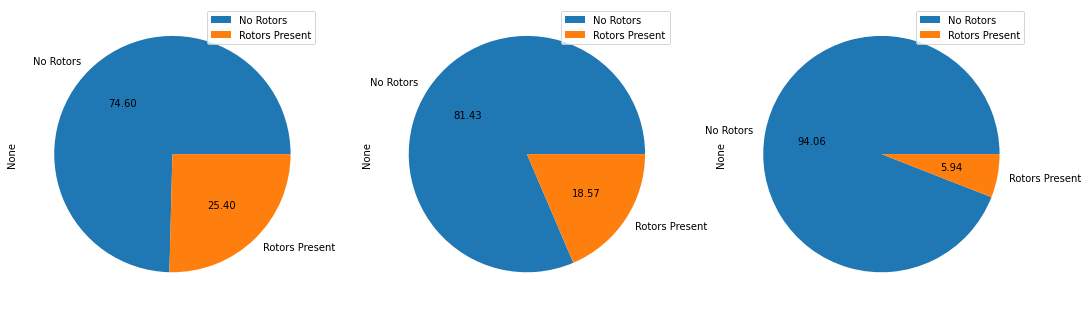

In [44]:
fig1 = matplotlib.pyplot.figure('comparison of class frequencies for different thresholds', figsize=(18,6))
ax1 = fig1.add_subplot(1,3,1)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-3 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)
ax1 = fig1.add_subplot(1,3,2)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-2 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)
ax1 = fig1.add_subplot(1,3,3)
pandas.Series(rse_rotors_model.predict(X_val)[:,0] >2e-1 ).value_counts().plot.pie(legend=True, autopct='%.2f',labels=['No Rotors', 'Rotors Present'], ax=ax1)


For this model, we can choose different threshold to classify the result as *no rotors* vs *rotors present*. With different choices of threshold, we will get different metric results. We can choose the threshold that gives us the best performance for our particular requirements for the classifier.

In [45]:
y_train_pred_raw = rse_rotors_model.predict(X_train)[:,0]
y_val_pred_raw = rse_rotors_model.predict(X_val)[:,0]

In [46]:
thresholds_list = list(numpy.arange(1e-3,0.3,1e-3))

In [47]:
hit_rates = []
hit_rates_test = []
false_alarm_rates = []
false_alarm_rates_test = []
sedi_list = []
sedi_list_test = []
for threshold in numpy.arange(1e-3,0.3,1e-3):
    y_pred_train = list(map(float, y_train_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_train[:,0], y_pred_train)
    hit_rates += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list += [calc_sedi(cm1)]

    y_pred_val = list(map(float, y_val_pred_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_val[:,0], y_pred_val )
    hit_rates_test += [cm1[1,1] / (cm1[1,0] + cm1[1,1])]
    false_alarm_rates_test += [cm1[0,1] / (cm1[0,0] + cm1[0,1])]
    sedi_list_test += [calc_sedi(cm1)]

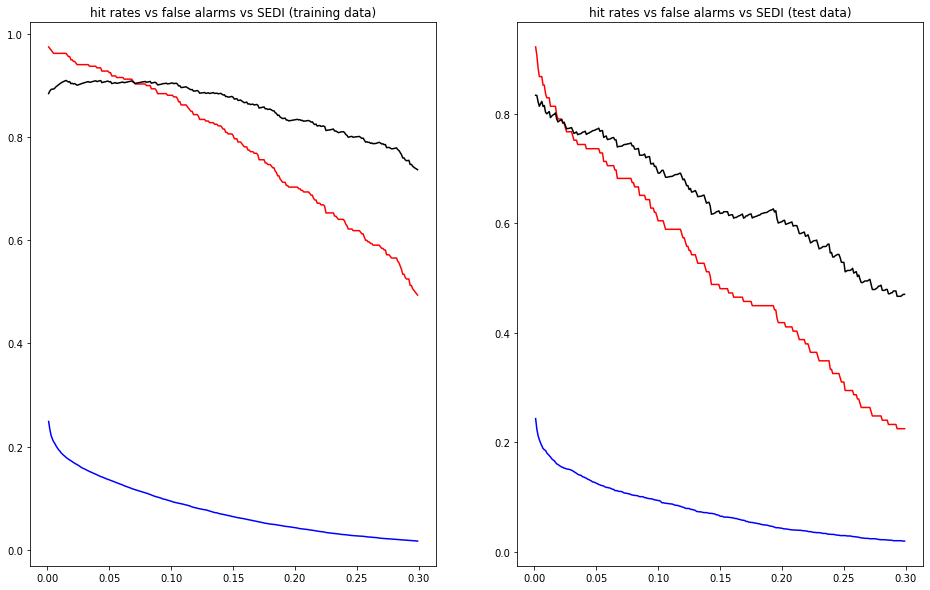

In [48]:
f1 = matplotlib.pyplot.figure(figsize=(16,10))
ax1 = f1.add_subplot(1,2,1,title='hit rates vs false alarms vs SEDI (training data)')
ax1.plot(thresholds_list, hit_rates,'r')
ax1.plot(thresholds_list, false_alarm_rates,'b')
ax1.plot(thresholds_list, sedi_list,'k')

ax1 = f1.add_subplot(1,2,2,title='hit rates vs false alarms vs SEDI (test data)')
ax1.plot(thresholds_list, hit_rates_test,'r')
ax1.plot(thresholds_list, false_alarm_rates_test,'b')
ax1.plot(thresholds_list, sedi_list_test,'k')

### Example - Dashboard to visualise results

In [49]:
import panel

In [50]:
panel.extension()

In [69]:
def plot_rotors_metrics(rotors_model,  X_dict, y_dict, selected_split, threshold,):
    y_raw = rotors_model.predict(X_dict[selected_split])[:,0]
    y_pred = list(map(float, y_raw > threshold)) 
    cm1 = sklearn.metrics.confusion_matrix(y_dict[selected_split], y_pred)
    metric_dict = {
        'hit_rate' : [cm1[1,1] / (cm1[1,0] + cm1[1,1])],
        'false_alarm_rate' : [cm1[0,1] / (cm1[0,0] + cm1[0,1])],
        'sedi_score': [calc_sedi(cm1)],
    }
    
    fig1 = matplotlib.pyplot.Figure()
    ax1 = fig1.add_subplot(1,1,1)
    pandas.DataFrame.from_dict(metric_dict).transpose().plot.bar(ax=ax1)
    ax1.set_ylim([0.0, 1.0])
    fig1.tight_layout()
    return fig1


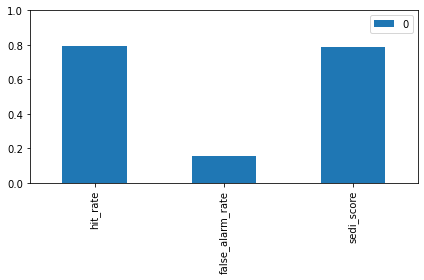

In [70]:
plot_rotors_metrics(
    rotors_model=rse_rotors_model,
    X_dict= {'train': X_train, 'val': X_val},
    y_dict= {'train': y_train[:,0], 'val': y_val[:,0]},
    selected_split='val',
    threshold=0.02,
)

In [53]:
split_select_widget = panel.widgets.Select(options=['train', 'val'])

In [54]:
threshold_widget = panel.widgets.slider.FloatSlider(start=0.0,end=0.2,step=0.001, value=0.01)

In [71]:
metric_plotter = panel.bind(
    functools.partial(plot_rotors_metrics, 
                      rotors_model=rse_rotors_model,
                      X_dict= {'train': X_train, 'val': X_val},
                      y_dict= {'train': y_train[:,0], 'val': y_val[:,0]},),
    selected_split=split_select_widget,
    threshold=threshold_widget,    
)

In [72]:
metric_dashboard = panel.Column(panel.Row(split_select_widget, threshold_widget), metric_plotter)

Column
    [0] Row
        [0] Select(options=['train', 'val'], value='val')
        [1] FloatSlider(end=0.2, step=0.001, value=0.03)
    [1] ParamFunction(function)
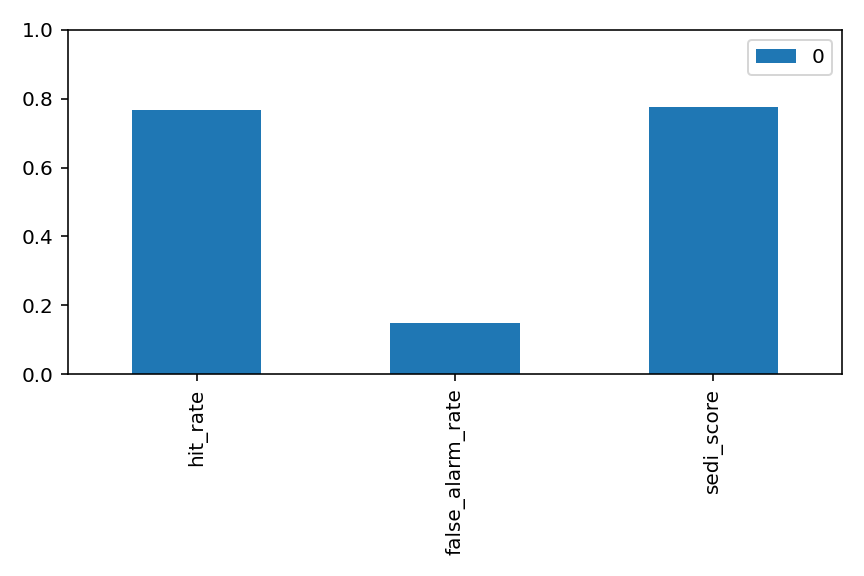

In [73]:
metric_dashboard.servable()

Our very basic dashboard is:
* loading data from a catalog
* loading a pre-trained model from catalog of pretrained models
* display plots  created on demand through an interactive dashboard.

Although this seems very simple (well, it is), this is a very scalable approach. We can easily make this better by
* Using a larger dataset.
* scaling up the calculation required through a workflow engine (e..g. dask, ray)
* run this on the cloud
* use more complicated/interesting plots



# Example - Explainable AI

In [ ]:
mlflow.shap.

### Reference

* [Holoviz](https://holoviz.org/) 
* SHAP
* 